In [1]:
!pip install gym gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 29.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 39.9 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827624 sha256=a0b1080747c719e4961f1d0c65907e05a293a985a45c7462c1a804e6a7fc0222
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym


In [1]:
!rm logs/train.log

In [2]:
import logging

# Configure the logger
def setup_logger(log_file="logs/train.log", log_level=logging.INFO):
    # Create logger
    logger = logging.getLogger(__name__)
    logger.setLevel(log_level)

    # Create file handler
    file_handler = logging.FileHandler(log_file)
    file_handler.setLevel(log_level)

    # Create formatter and add it to the handler
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)

    # Add the handler to the logger
    logger.addHandler(file_handler)

    return logger

logger = setup_logger()

In [3]:
from environment import CompetitiveSudokuEnv
from sudoku import Move
from random_player import SudokuAI
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

env = CompetitiveSudokuEnv(board_file="../boards/empty-3x3.txt", agent_player=1)

class DQN(nn.Module):
    def __init__(self, input_dim=81, output_dim=81):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        # self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(512, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        return self.fc3(x)

# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         # Kaiming Uniform is often good for ReLU
#         nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
#         # Or use kaiming_normal_ if you prefer.
        
#         # Initialize biases to zero (common practice)
#         nn.init.constant_(m.bias, 0.0)    

board_len = 9
compute_reward_episodes = 10
save_model_episodes = 10
show_q_stats_steps = 500

# Parameters
learning_rate = 1e-5 #
gamma = 0.95

epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.999
batch_size = 256
# tau = 0.001
target_update_frequency = 5_000
memory_size = 200_000
episodes = 10_000

input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
policy_net = DQN(input_dim, output_dim)
# policy_net.apply(init_weights)
target_net = DQN(input_dim, output_dim)
# target_net.apply(init_weights)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=learning_rate, amsgrad=True)
memory = deque(maxlen=memory_size)


In [4]:
import random

def select_action(env, state, epsilon):
    allowed = env.get_allowed_inds()
    if len(allowed) == 0:
        return None
    if random.random() < epsilon:
        if len(allowed) == 0:
            env.render()
        idx = random.choice(allowed)
        i, j = idx // board_len, idx % board_len
        return Move(square=(i, j), value=SudokuAI.get_possible_value(env.game_state, i, j))
    else:
         with torch.no_grad():
            state_tensor = torch.Tensor(state)
            q_values = policy_net(state_tensor)
            max_idx = torch.argmax(q_values[allowed])
            i, j = allowed[max_idx] // board_len, allowed[max_idx] % board_len
            return Move(square=(i, j), value=SudokuAI.get_possible_value(env.game_state, i, j))
         
losses = []
avg_qs = []
max_qs = []

def optimize_model(verbose=False):
    if len(memory) < batch_size:
        return
    
    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

    state_batch = torch.FloatTensor(state_batch)
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(next_state_batch)
    done_batch = torch.FloatTensor(done_batch)

    # Compute Q-values for current states
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Compute target Q-values using the target network
    with torch.no_grad():
        # Next actions come from the policy net
        next_actions = policy_net(next_state_batch).argmax(1).unsqueeze(1)

        # Q-values for these actions come from the target net
        next_q_values_ddqn = target_net(next_state_batch).gather(1, next_actions).squeeze(1)

        target_q_values = reward_batch + gamma * next_q_values_ddqn * (1 - done_batch)


    loss = nn.SmoothL1Loss()(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    
    # torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=10.0)
    
    optimizer.step()

    # Log the loss
    losses.append(loss.item())
    if verbose:
        logger.info(f"Loss: {loss.item()}")
        with torch.no_grad():
            q_values_all = policy_net(state_batch)
            avg_q = q_values_all.mean().item()
            avg_qs.append(avg_q)
            max_q = q_values_all.max().item()
            max_qs.append(max_q)
            logger.info(f"Avg Q: {avg_q:.2f}, Max Q: {max_q:.2f}")
        
        
def evaluate_trained_agent(n_games=10):
    env_test = CompetitiveSudokuEnv(board_file="../boards/empty-3x3.txt", agent_player=1)
    total_reward = 0

    for game in range(n_games):
        state, _ = env_test.reset()
        episode_reward = 0
        done = False

        while not done:
            action = select_action(env_test, state, 0)
            if action is None:
                break
            next_state, reward, done, _, _ = env_test.step(action)
            # env_test.render()
            state = next_state
            episode_reward += reward

        # print(episode_reward)
        total_reward += episode_reward

    average_reward = total_reward / n_games
    return average_reward

In [ ]:
rewards = []
steps_done = 0

for episode in range(episodes):
    logger.info(f"Episode: {episode + 1}")
    state, _ = env.reset()
    done = False
    
    while not done:
        action = select_action(env, state, epsilon)
        next_state, reward, done, _, info = env.step(action)
        # env.show_info(info)
        # env.render()
        
        if next_state is None or action is None:
            env.render()
        
        numeric_action = action.square[0] * board_len + action.square[1]
        memory.append((state, numeric_action, reward, next_state, done))
    
        state = next_state
        
        if steps_done % show_q_stats_steps == 0:
            optimize_model(True)
        else:
            optimize_model(False)
        
        # target_net_state_dict = target_net.state_dict()
        # policy_net_state_dict = policy_net.state_dict()
        # for key in policy_net_state_dict:
        #     target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
        # target_net.load_state_dict(target_net_state_dict)
        
        if steps_done % target_update_frequency == 0:
            target_net.load_state_dict(policy_net.state_dict())
            logger.info(f"Target network updated at step {steps_done}")

        steps_done += 1
    
    if (episode + 1) % compute_reward_episodes == 0:
        average_reward = evaluate_trained_agent(20)
        rewards.append(average_reward)
        logger.info(f"Average Reward: {average_reward:.4f}")

    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    logger.info(f"Epsilon: {epsilon:.4f}")
    if len(losses) > 0:
        logger.info(f"Loss: {losses[-1]:.4f}")
        

    
    if (episode + 1) % save_model_episodes == 0:
        torch.save(policy_net.state_dict(), f"model/model{episode + 1}.pt")

torch.save(policy_net.state_dict(), "model.pt")

In [ ]:
import matplotlib.pyplot as plt
plt.plot(rewards[600:620])
plt.show()

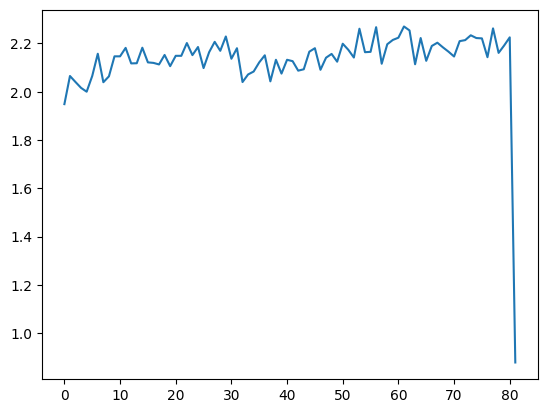

In [8]:
step = 10
res = []
for i in range(0, len(rewards), step):
    res.append(sum(rewards[i:i+step]) / step)
plt.plot(res)
plt.show()